In [1]:
from pathlib import Path
import os

os.chdir(Path.cwd().parent)
assert (Path.cwd() / "pyproject.toml").exists()

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

from pmrisk.config import settings
from pmrisk.labeling.labels import build_labeled_df
from pathlib import Path

In [3]:
df = pd.read_parquet(Path(settings.data_processed_dir) / "fd001_train.parquet")

In [4]:
labeled_path = Path(settings.data_processed_dir) / "fd001_train_labeled.parquet"
if labeled_path.exists():
    df_labeled = pd.read_parquet(labeled_path)
else:
    df_labeled = build_labeled_df(df)

In [5]:
print(f"Rows: {len(df)}")
print(f"Engines: {df['engine_id'].nunique()}")
print("\nCycles per engine:")
print(df.groupby("engine_id")["cycle"].max().describe())

Rows: 20631
Engines: 100

Cycles per engine:
count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: cycle, dtype: float64


In [6]:
print("Missingness (top 10):")
print(df.isna().mean().sort_values(ascending=False).head(10))

Missingness (top 10):
engine_id       0.0
cycle           0.0
op_setting_1    0.0
op_setting_2    0.0
op_setting_3    0.0
sensor_1        0.0
sensor_2        0.0
sensor_3        0.0
sensor_4        0.0
sensor_5        0.0
dtype: float64


In [7]:
print(f"Positive rate: {df_labeled['label'].mean():.4f}")
print("\nLabel counts:")
print(df_labeled["label"].value_counts())

Positive rate: 0.1907

Label counts:
label
0    12731
1     3000
Name: count, dtype: int64


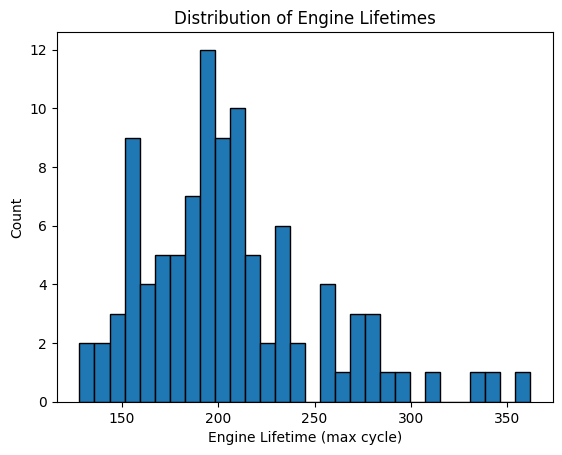

In [8]:
lifetimes = df.groupby("engine_id")["cycle"].max()
plt.hist(lifetimes, bins=30, edgecolor="black")
plt.xlabel("Engine Lifetime (max cycle)")
plt.ylabel("Count")
plt.title("Distribution of Engine Lifetimes")
plt.show()

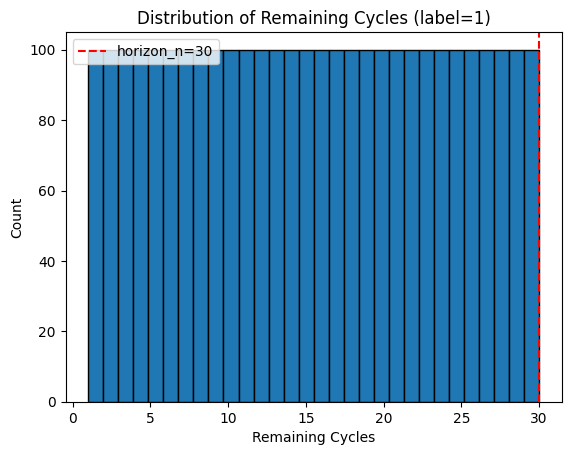

In [9]:
remaining_positive = df_labeled[df_labeled["label"] == 1]["remaining"]
plt.hist(remaining_positive, bins=30, edgecolor="black")
plt.xlabel("Remaining Cycles")
plt.ylabel("Count")
plt.title("Distribution of Remaining Cycles (label=1)")
plt.axvline(settings.horizon_n, color="r", linestyle="--", label=f"horizon_n={settings.horizon_n}")
plt.legend()
plt.show()

In [11]:
print("Remaining min/max:", df_labeled["remaining"].min(), df_labeled["remaining"].max())
print("Positives per engine (sum label) describe:")
print(df_labeled.groupby("engine_id")["label"].sum().describe())

Remaining min/max: 0 312
Positives per engine (sum label) describe:
count    100.0
mean      30.0
std        0.0
min       30.0
25%       30.0
50%       30.0
75%       30.0
max       30.0
Name: label, dtype: float64


In [12]:
print("Rows after window filter:", len(df_labeled), "of", len(df))

Rows after window filter: 15731 of 20631


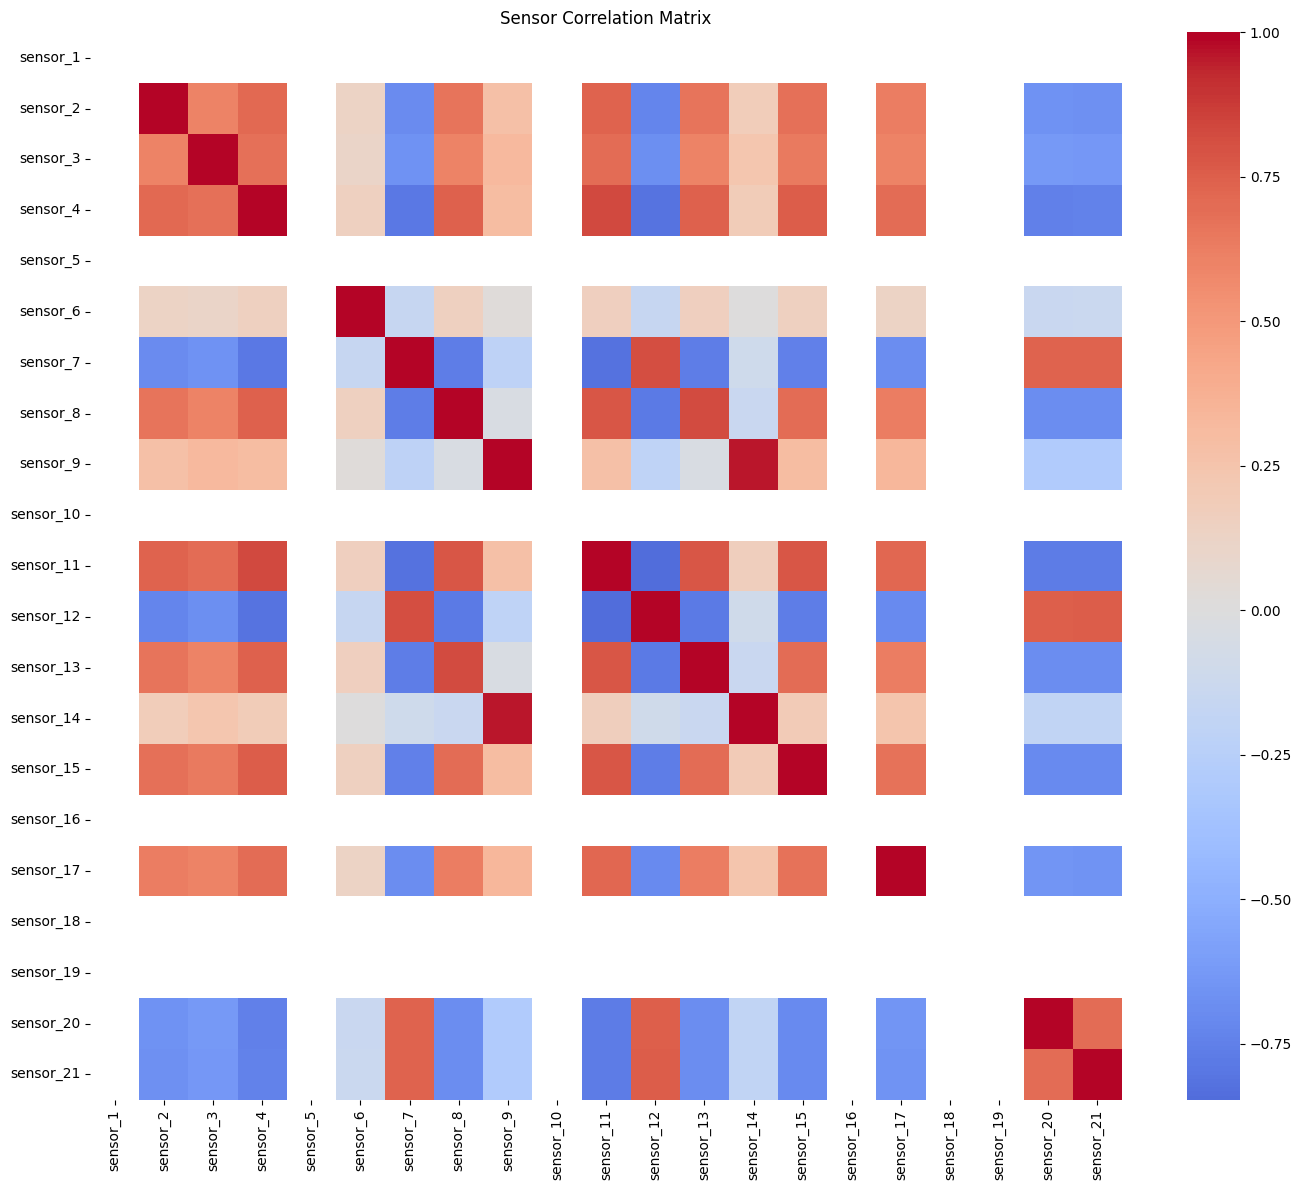

Highly correlated sensor pairs (|r| > 0.9):
  sensor_9 <-> sensor_14: 0.963


In [13]:
import seaborn as sns

sensor_cols = [c for c in df.columns if c.startswith("sensor_")]

corr = df[sensor_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, fmt=".2f")
plt.title("Sensor Correlation Matrix")
plt.tight_layout()
plt.show()

high_corr = []
for i, col1 in enumerate(sensor_cols):
    for col2 in sensor_cols[i+1:]:
        c = corr.loc[col1, col2]
        if abs(c) > 0.9:
            high_corr.append((col1, col2, round(c, 3)))

print("Highly correlated sensor pairs (|r| > 0.9):")
for pair in high_corr:
    print(f"  {pair[0]} <-> {pair[1]}: {pair[2]}")

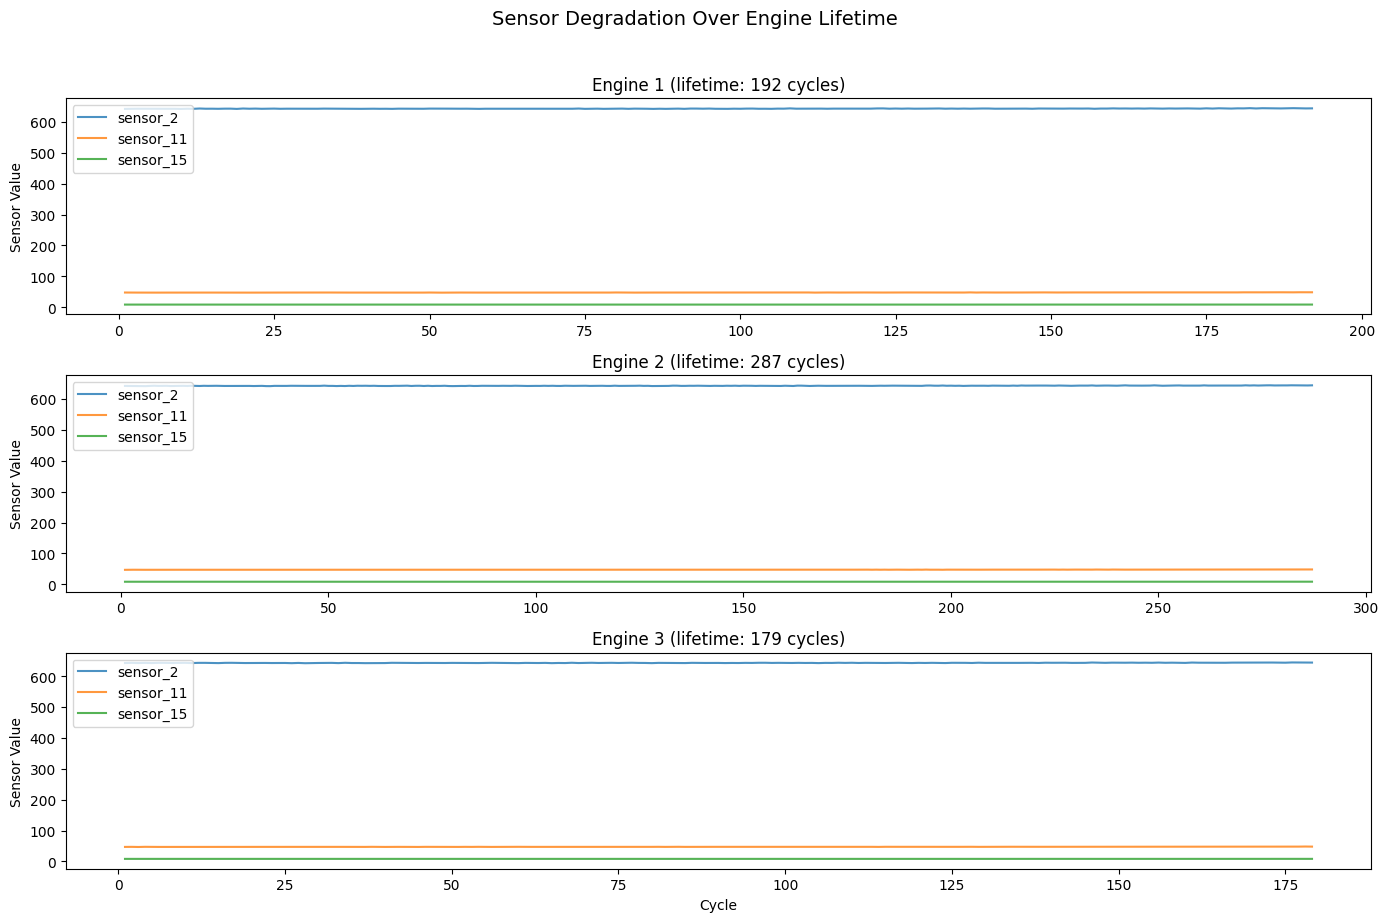

In [14]:
sample_engines = df["engine_id"].unique()[:3]
sensors_to_plot = ["sensor_2", "sensor_11", "sensor_15"]

fig, axes = plt.subplots(len(sample_engines), 1, figsize=(14, 3 * len(sample_engines)), sharex=False)

for ax, engine_id in zip(axes, sample_engines):
    engine_df = df[df["engine_id"] == engine_id]
    for sensor in sensors_to_plot:
        ax.plot(engine_df["cycle"], engine_df[sensor], label=sensor, alpha=0.8)
    ax.set_ylabel("Sensor Value")
    ax.set_title(f"Engine {engine_id} (lifetime: {engine_df['cycle'].max()} cycles)")
    ax.legend(loc="upper left")

axes[-1].set_xlabel("Cycle")
fig.suptitle("Sensor Degradation Over Engine Lifetime", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

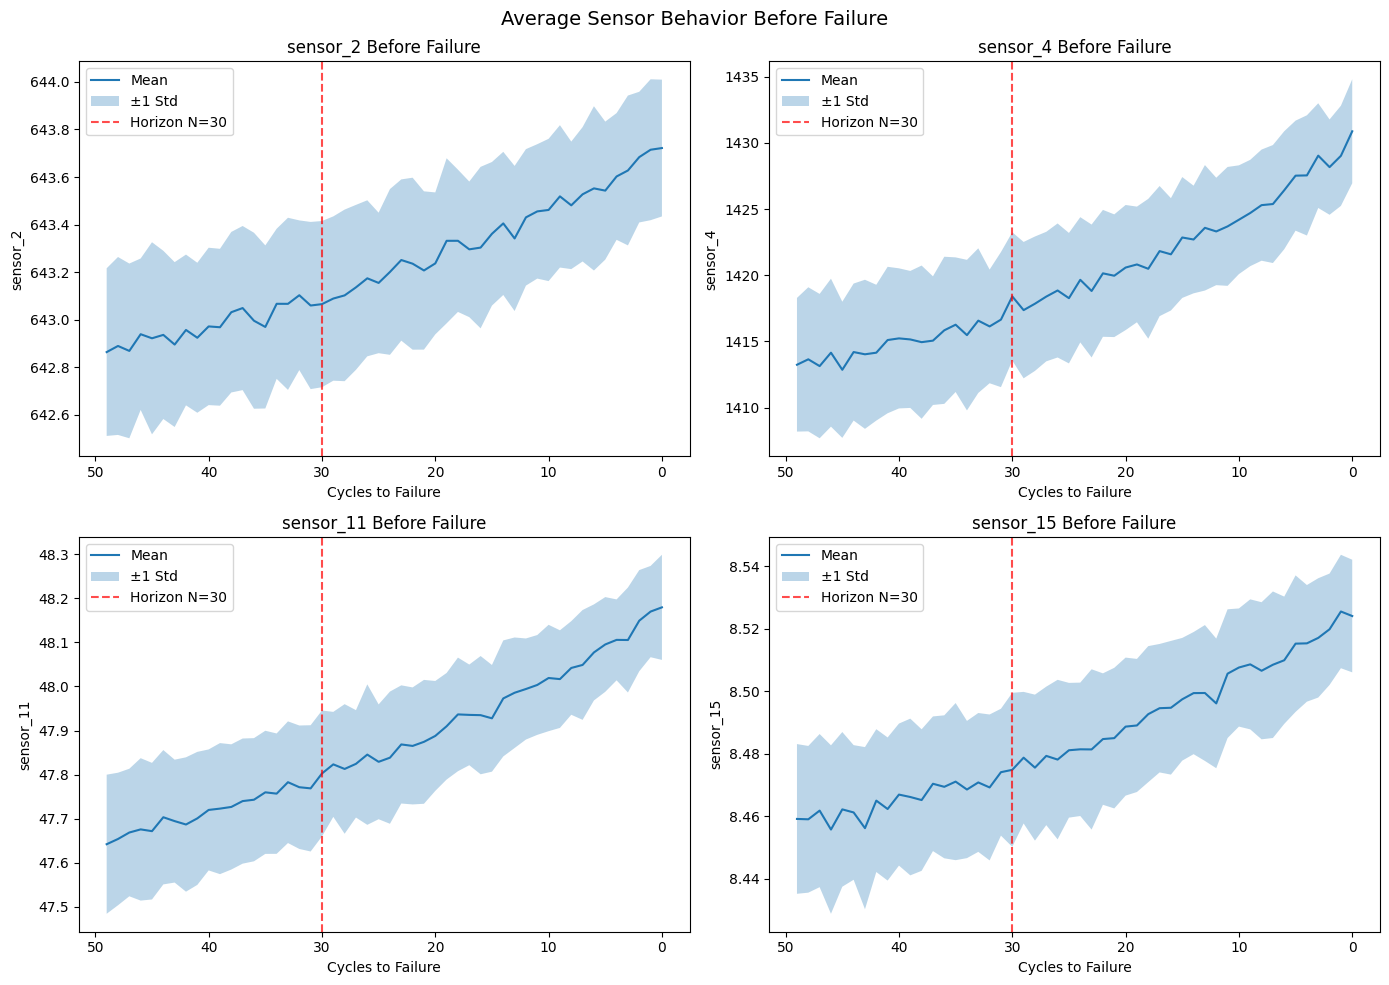

In [15]:
last_n = 50
sensors_to_analyze = ["sensor_2", "sensor_4", "sensor_11", "sensor_15"]

aligned_data = []

for engine_id in df["engine_id"].unique():
    engine_df = df[df["engine_id"] == engine_id].copy()
    engine_df = engine_df.sort_values("cycle")
    engine_df["cycles_to_failure"] = engine_df["cycle"].max() - engine_df["cycle"]
    engine_df = engine_df[engine_df["cycles_to_failure"] < last_n]
    aligned_data.append(engine_df)

aligned_df = pd.concat(aligned_data, ignore_index=True)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, sensor in zip(axes, sensors_to_analyze):
    grouped = aligned_df.groupby("cycles_to_failure")[sensor].agg(["mean", "std"])
    ax.plot(grouped.index, grouped["mean"], label="Mean")
    ax.fill_between(
        grouped.index,
        grouped["mean"] - grouped["std"],
        grouped["mean"] + grouped["std"],
        alpha=0.3,
        label="±1 Std"
    )
    ax.set_xlabel("Cycles to Failure")
    ax.set_ylabel(sensor)
    ax.set_title(f"{sensor} Before Failure")
    ax.invert_xaxis()
    ax.axvline(settings.horizon_n, color="r", linestyle="--", alpha=0.7, label=f"Horizon N={settings.horizon_n}")
    ax.legend()

plt.suptitle("Average Sensor Behavior Before Failure", fontsize=14)
plt.tight_layout()
plt.show()

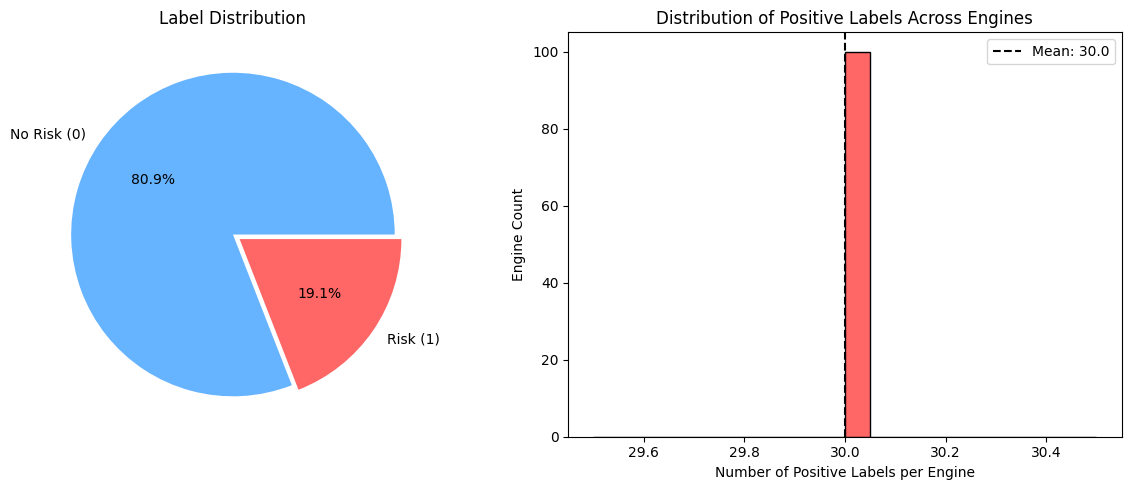

Imbalance ratio: 1:4.2 (negative:positive)


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

label_counts = df_labeled["label"].value_counts()
axes[0].pie(
    label_counts.values,
    labels=["No Risk (0)", "Risk (1)"],
    autopct="%1.1f%%",
    colors=["#66b3ff", "#ff6666"],
    explode=(0, 0.05)
)
axes[0].set_title("Label Distribution")

positives_per_engine = df_labeled.groupby("engine_id")["label"].sum()
axes[1].hist(positives_per_engine, bins=20, edgecolor="black", color="#ff6666")
axes[1].set_xlabel("Number of Positive Labels per Engine")
axes[1].set_ylabel("Engine Count")
axes[1].set_title("Distribution of Positive Labels Across Engines")
axes[1].axvline(positives_per_engine.mean(), color="black", linestyle="--", label=f"Mean: {positives_per_engine.mean():.1f}")
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Imbalance ratio: 1:{label_counts[0] / label_counts[1]:.1f} (negative:positive)")

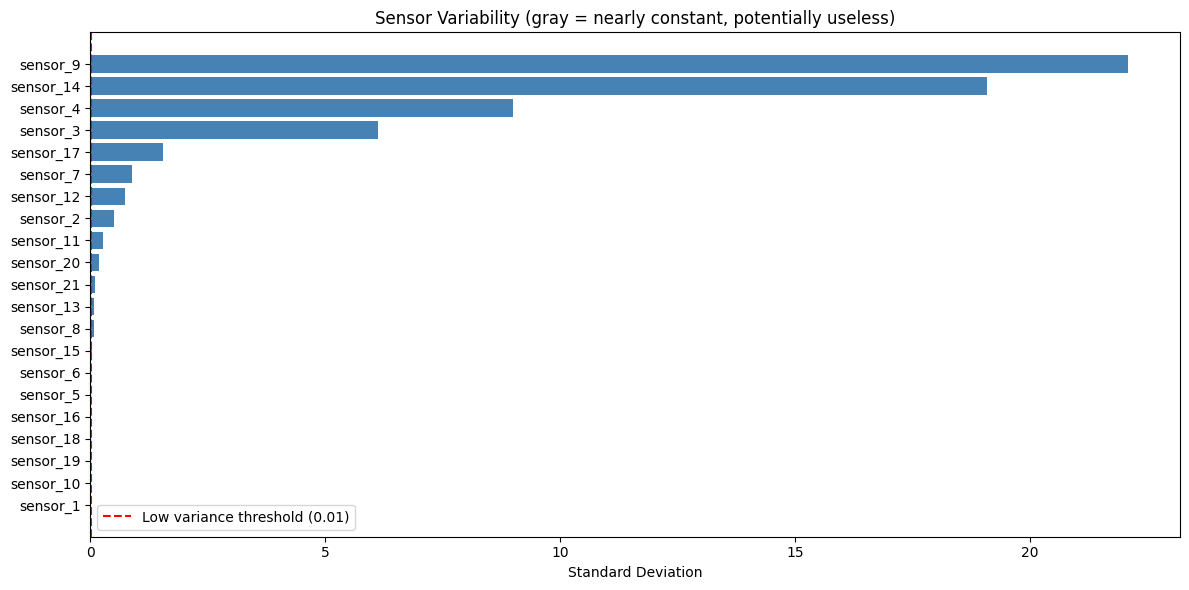

Low-variance sensors (std < 0.01): ['sensor_1', 'sensor_10', 'sensor_19', 'sensor_18', 'sensor_16', 'sensor_5', 'sensor_6']


In [17]:
sensor_cols = [c for c in df.columns if c.startswith("sensor_")]
sensor_std = df[sensor_cols].std().sort_values()

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(sensor_std.index, sensor_std.values, color="steelblue")

low_var_threshold = 0.01
for bar, val in zip(bars, sensor_std.values):
    if val < low_var_threshold:
        bar.set_color("lightgray")

ax.axvline(low_var_threshold, color="red", linestyle="--", label=f"Low variance threshold ({low_var_threshold})")
ax.set_xlabel("Standard Deviation")
ax.set_title("Sensor Variability (gray = nearly constant, potentially useless)")
ax.legend()
plt.tight_layout()
plt.show()

low_var_sensors = sensor_std[sensor_std < low_var_threshold].index.tolist()
print(f"Low-variance sensors (std < {low_var_threshold}): {low_var_sensors}")

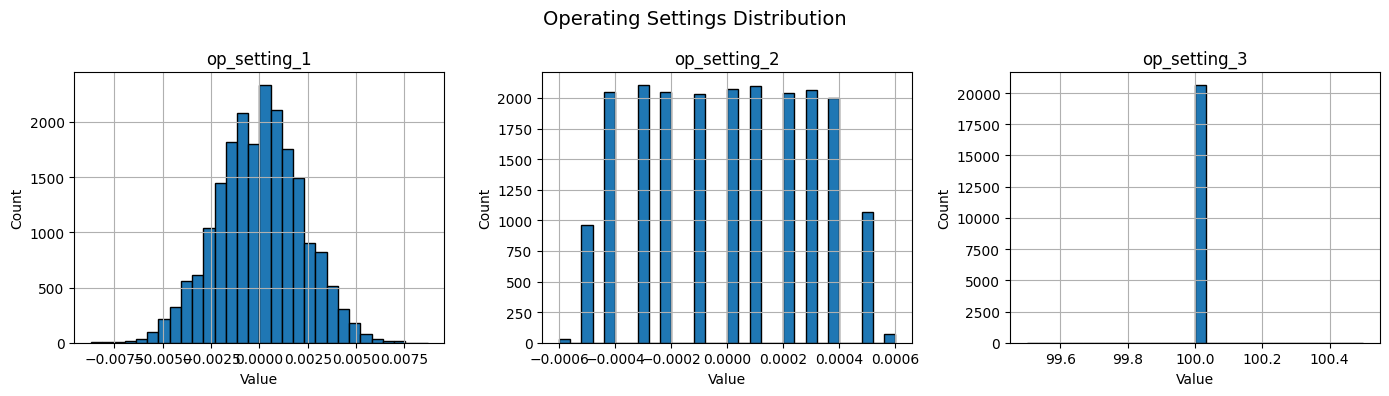

Operating settings unique values:
  op_setting_1: 158 unique values
  op_setting_2: 13 unique values
  op_setting_3: 1 unique values


In [18]:
op_cols = [c for c in df.columns if c.startswith("op_setting_")]

fig, axes = plt.subplots(1, len(op_cols), figsize=(14, 4))

for ax, col in zip(axes, op_cols):
    df[col].hist(ax=ax, bins=30, edgecolor="black")
    ax.set_title(col)
    ax.set_xlabel("Value")
    ax.set_ylabel("Count")

plt.suptitle("Operating Settings Distribution", fontsize=14)
plt.tight_layout()
plt.show()

print("Operating settings unique values:")
for col in op_cols:
    print(f"  {col}: {df[col].nunique()} unique values")